In [105]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.pylab as pylab

# Useful plotting thingies:
%matplotlib inline
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = 16, 16


In [106]:
import tables as tb
from sklearn.preprocessing import Normalizer, scale

# Set up the experimental matrices:
targets = ['ADAS11_bl', 'ADAS13_bl', 'MMSE_bl']
varnames = ['CT_VOL', 'L_HC_VOL', 'R_HC_VOL']
targets_regex = '|'.join(['^{}$'.format(t) for t in targets])
#modalities = ['CT', 'L_HC', 'R_HC']
modalities = ['CT']
l_segment_regex = '^L_HC_'
r_segment_regex = '^R_HC_'
modalities_regex = '|'.join(['^{}_'.format(m) for m in modalities])

matrices = []
l_D = []
r_D = []
for split in ['train', 'valid', 'test']:
    frame = pd.read_pickle('/projects/francisco/data/ADNI/cli_ct_seg_fused_{}.pkl'.format(split))
    ct = frame.filter(regex=modalities_regex).as_matrix()
    y_cur = frame.filter(regex=targets_regex).as_matrix()
    y_cur[np.isnan(y_cur)] = np.nanmean(y_cur)
    l_segs = frame.filter(regex=l_segment_regex).as_matrix()
    r_segs = frame.filter(regex=r_segment_regex).as_matrix()
    ct_vol = np.sum(ct, axis=1)
    l_hc_vol = np.sum(l_segs, axis=1)
    r_hc_vol = np.sum(r_segs, axis=1)
    matrices.append([y_cur, ct_vol, l_hc_vol, r_hc_vol])
    

In [107]:
def adjusted_r2(y_hat, y, p, n):
    """
    And I quote:
    "adjusted R2 is a comparative measure of suitability of alternative nested sets of explanators"
    """
    r2 = metrics.r2_score(y_hat, y)
    adj_r2 = r2 - (1 - r2) * (p / n - p - 1)
    return r2
    

In [108]:
from sklearn.linear_model import SGDRegressor, BayesianRidge, RidgeCV
from sklearn.decomposition import RandomizedPCA
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_regression
from sklearn import metrics

num_targets = len(targets)
num_models = 3 # Includes dummy model
k_classifiers = []
k_selectors = []
stats = np.zeros(shape=(3, 3, num_models, num_targets))
for i in range(3):
    X, y = matrices[0][i+1].reshape((-1,1)), matrices[0][0]
    X_v, y_v = matrices[1][i+1].reshape((-1,1)), matrices[1][0]
    X_t, y_t = matrices[2][i+1].reshape((-1,1)), matrices[2][0]
    
    
    cur_triple = []
    cur_sel_triple = []
    for t in range(0,len(targets)):
        
        dummy_regressor = DummyRegressor(strategy='mean')
        classifier = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=None, fit_intercept=True, scoring=None, normalize=False)
        classifiers = [classifier, dummy_regressor]
        
        # Train classifiers on transformed training X
        #print X
        #print y[:,t]
    
        classifier.fit(X, y[:,t])
        dummy_regressor.fit(X, y[:,t])
        
        # Save classifiers for visualizing on later
        cur_triple.append((classifier, dummy_regressor))

        # Predict on validation data and log stats
        y_hat_v = classifier.predict(X_v)
        y_hat_vd = dummy_regressor.predict(X_v)
        stats[i,0,0,t] =  metrics.mean_squared_error(y_hat_v, y_v[:,t])
        stats[i,1,0,t] =  adjusted_r2(y_hat_v, y_v[:,t], X_v.shape[1], X_v.shape[0])
        stats[i,0,2,t] =  metrics.mean_squared_error(y_hat_vd, y_v[:,t])
        stats[i,1,2,t] =  adjusted_r2(y_hat_vd, y_v[:,t], X_v.shape[1], X_v.shape[0])
    k_selectors.append(cur_sel_triple)
    k_classifiers.append(cur_triple)



In [109]:
print stats.shape
print len(k_classifiers)
print k_classifiers

(3, 3, 3, 3)
3
[[(RidgeCV(alphas=[0.1, 1.0, 10.0], cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False), DummyRegressor(constant=None, quantile=None, strategy='mean')), (RidgeCV(alphas=[0.1, 1.0, 10.0], cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False), DummyRegressor(constant=None, quantile=None, strategy='mean')), (RidgeCV(alphas=[0.1, 1.0, 10.0], cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False), DummyRegressor(constant=None, quantile=None, strategy='mean'))], [(RidgeCV(alphas=[0.1, 1.0, 10.0], cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False), DummyRegressor(constant=None, quantile=None, strategy='mean')), (RidgeCV(alphas=[0.1, 1.0, 10.0], cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False), DummyRegressor(constant=None, quantile=N

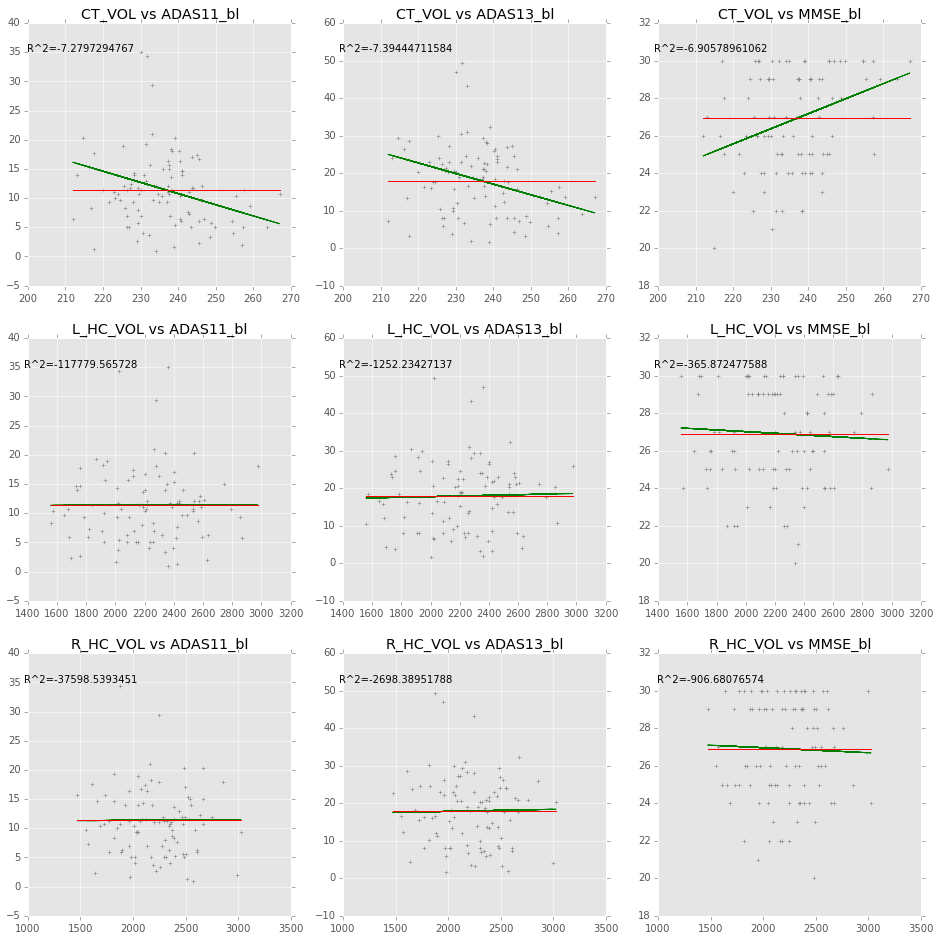

In [110]:
from tabulate import tabulate

f = 0
for v, vname in enumerate(varnames):
    X, y = matrices[0][v+1].reshape((-1,1)), matrices[0][0]
    X_v, y_v = matrices[1][v+1].reshape((-1,1)), matrices[1][0]
    for t, tname in enumerate(targets):
        regr = k_classifiers[v][t][0]
        dummy = k_classifiers[v][t][1]
        f += 1  
        ax=plt.subplot(3,3,f)
        plt.title('{} vs {}'.format(vname, tname))
        # Plot outputs
        plt.scatter(X_v, y_v[:,t], marker='+', color='gray')
        plt.plot(X_v, regr.predict(X_v), color='green', linewidth=1)
        plt.plot(X_v, dummy.predict(X_v), color='red', linewidth=1)
        plt.text(0.2, 0.9,'R^2={}'.format(stats[v,1,0,t]), horizontalalignment='center', verticalalignment='center', transform = ax.transAxes)

plt.grid()    
plt.show()

